In [1]:
import torchvision
from torchvision import utils
from torchvision import datasets
from torchvision import models
import torchvision.transforms as T
import torchvision.datasets as D

from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
import argparse
import datetime
import os

from lib.models import build_model


%matplotlib inline 
from matplotlib import pyplot as plt


/home/lsj/.conda/envs/teach_augment/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = 'MNIST'
root = '/hdd/hdd4/lsj/torchvision_dataset/MNIST'
log_dir = '/hdd/hdd4/lsj/teach_augment'

In [3]:
transform = T.Compose([ T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])
trainset = datasets.MNIST(root=root, train=True, download=True, transform=transform)
testset = datasets.MNIST(root=root, train=False, download=True, transform=transform)

In [4]:
active_indices = {}

for i in range(0, 50):
    if trainset[i][1] not in active_indices:
        active_indices[trainset[i][1]] = [i]
    else:
        active_indices[trainset[i][1]].append(i)

In [5]:
active_indices

{5: [0, 11, 35, 47],
 0: [1, 21, 34, 37],
 4: [2, 9, 20, 26],
 1: [3, 6, 8, 14, 23, 24, 40],
 9: [4, 19, 22, 33, 43, 45, 48],
 2: [5, 16, 25, 28],
 3: [7, 10, 12, 27, 30, 44, 49],
 6: [13, 18, 32, 36, 39],
 7: [15, 29, 38, 42],
 8: [17, 31, 41, 46]}

In [6]:
train_indices = [0, 1, 2, 3, 4, 5, 7, 13, 15, 17]
len(train_indices)

10

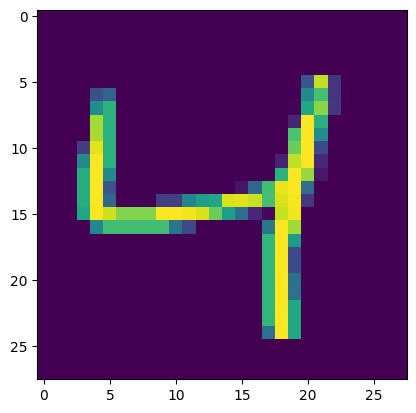

In [7]:
def to_img(array):
    return array.reshape(28,28)

plt.imshow(to_img(trainset[2][0]), interpolation='nearest')
plt.show()

In [8]:
train_indices = [0, 1, 2, 3, 4, 5, 7, 13, 15, 17]
trainset = torch.utils.data.Subset(trainset, train_indices)
print(f'len(trainset): {len(trainset)}')


len(trainset): 10


In [9]:
batch_size = 10
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=8)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)


In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

n_classes = 100 if dataset == 'CIFAR100' else 10
n_channel = 1 if dataset == 'MNIST' else 3


cuda


In [48]:
model = build_model('wrn-28-10', n_classes, n_channel).to(device)

lr = 0.05
num_epochs = 200

optimizer = optim.Adam(model.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss().to(device)

In [49]:
params = {
    'num_epochs': num_epochs,
    'optimizer': optimizer,
    'loss_function': loss_function,
    'train_dataloader': train_dataloader,
    'test_dataloader': test_dataloader,
    'device': device
}

In [50]:
log_dir = '/hdd/hdd4/lsj/teach_augment'
log_dir = os.path.join(log_dir, 'MNIST-overfit-to-aug')
if not os.path.exists(log_dir):
    os.makedirs(log_dir)


In [51]:
print(log_dir)

/hdd/hdd4/lsj/teach_augment/MNIST-overfit-to-aug


In [52]:
list_train_loss = []
list_train_accuracy = []
list_test_loss = []
list_test_accuracy = []


for epoch in range(1, num_epochs+1):
    model.train()
    train_loss_sum = 0.0
    train_correct = 0

    for i, data in enumerate(train_dataloader, 0):
#         print(f'epoch: {epoch}, i: {i}')
        # train dataloader 로 불러온 데이터에서 이미지와 라벨을 분리
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 이전 batch에서 계산된 가중치를 초기화
        optimizer.zero_grad() 

        # forward + back propagation 연산
        outputs = model(inputs)
        train_loss = loss_function(outputs, labels)
        train_loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        train_loss_sum += train_loss.item() * len(inputs)

    final_train_loss = train_loss_sum / len(trainset)
    
    total = 0
    correct = 0
    test_loss_sum = 0.0

    model.eval()
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss = loss_function(outputs, labels)
            test_loss_sum += test_loss.item() * len(inputs)

    final_test_loss = test_loss_sum / len(testset)

    # 학습 결과 출력
    print('Epoch: %d, Train loss: %.6f, Test loss: %.6f, Accuracy: %.2f' %(epoch, final_train_loss, final_test_loss, 100*correct/total))
#     wandb.log({
#         'train/loss': final_train_loss,
#         'train/acc': train_correct/len(trainset),
#         'eval/loss': final_test_loss,
#         'eval/acc': correct/total,
#     })

    list_train_loss.append(final_train_loss)
    list_train_accuracy.append(train_correct/len(trainset))
    list_test_loss.append(final_test_loss)
    list_test_accuracy.append(correct/total)
    
    if epoch % 20 == 0:
        torch.save(model.state_dict(), os.path.join(log_dir, f'MNIST-one-per-class-wrn-28-10-epoch{epoch:02d}.pt'))


Epoch: 1, Train loss: 2.294552, Test loss: 845929777955708911079003258880.000000, Accuracy: 10.10
Epoch: 2, Train loss: 6.481812, Test loss: 3173819275411.456055, Accuracy: 9.58
Epoch: 3, Train loss: 8.766811, Test loss: 702077.592375, Accuracy: 9.74
Epoch: 4, Train loss: 6.729294, Test loss: 737.022195, Accuracy: 9.74
Epoch: 5, Train loss: 4.746076, Test loss: 1451.877799, Accuracy: 9.80
Epoch: 6, Train loss: 4.057286, Test loss: 37.250850, Accuracy: 10.28
Epoch: 7, Train loss: 3.007757, Test loss: 6.914935, Accuracy: 10.75
Epoch: 8, Train loss: 2.423146, Test loss: 95.362081, Accuracy: 10.18
Epoch: 9, Train loss: 2.015453, Test loss: 82.309636, Accuracy: 10.10
Epoch: 10, Train loss: 1.994524, Test loss: 64.629338, Accuracy: 10.10
Epoch: 11, Train loss: 2.005830, Test loss: 43.852001, Accuracy: 10.48
Epoch: 12, Train loss: 1.984534, Test loss: 24.262989, Accuracy: 11.01
Epoch: 13, Train loss: 1.965330, Test loss: 13.962226, Accuracy: 12.37
Epoch: 14, Train loss: 1.926699, Test loss: 9

Epoch: 117, Train loss: 0.001808, Test loss: 12.297048, Accuracy: 20.50
Epoch: 118, Train loss: 0.001763, Test loss: 12.338678, Accuracy: 20.48
Epoch: 119, Train loss: 0.001722, Test loss: 12.379906, Accuracy: 20.52
Epoch: 120, Train loss: 0.001685, Test loss: 12.433241, Accuracy: 20.56
Epoch: 121, Train loss: 0.001649, Test loss: 12.479419, Accuracy: 20.60
Epoch: 122, Train loss: 0.001614, Test loss: 12.513874, Accuracy: 20.60
Epoch: 123, Train loss: 0.001582, Test loss: 12.546478, Accuracy: 20.60
Epoch: 124, Train loss: 0.001550, Test loss: 12.569480, Accuracy: 20.60
Epoch: 125, Train loss: 0.001520, Test loss: 12.597332, Accuracy: 20.56
Epoch: 126, Train loss: 0.001492, Test loss: 12.611892, Accuracy: 20.57
Epoch: 127, Train loss: 0.001466, Test loss: 12.614489, Accuracy: 20.57
Epoch: 128, Train loss: 0.001442, Test loss: 12.617495, Accuracy: 20.54
Epoch: 129, Train loss: 0.001419, Test loss: 12.625858, Accuracy: 20.51
Epoch: 130, Train loss: 0.001397, Test loss: 12.635359, Accuracy

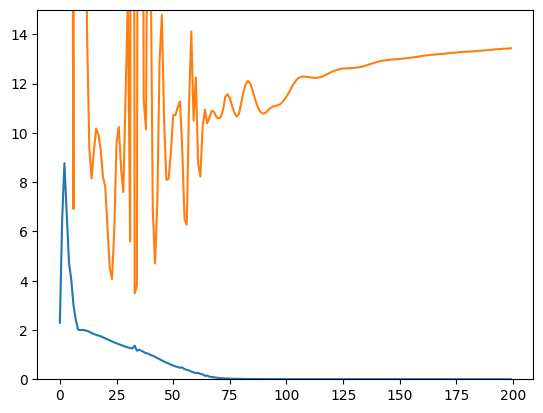

In [54]:
plt.ylim(0, 15)
plt.plot(list(range(0, 200)), list_train_loss)
plt.plot(list(range(0, 200)), list_test_loss)
plt.show()

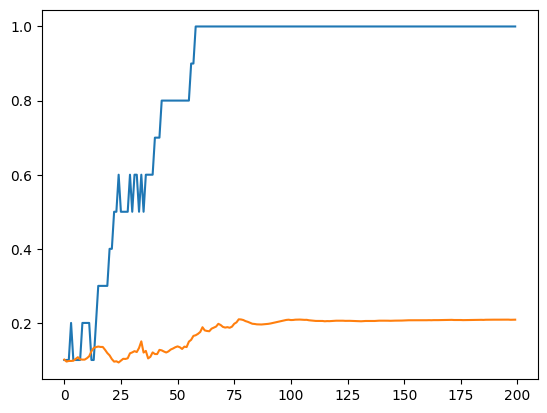

In [55]:
# plt.ylim(0, 15)
plt.plot(list(range(0, 200)), list_train_accuracy)
plt.plot(list(range(0, 200)), list_test_accuracy)
plt.show()

# Overfit to Aug?

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_classes = 100 if dataset == 'CIFAR100' else 10
n_channel = 1 if dataset == 'MNIST' else 3

model = build_model('wrn-28-10', n_classes, n_channel).to(device)
model.load_state_dict(torch.load('/hdd/hdd4/lsj/teach_augment/MNIST-overfit-to-aug/MNIST-one-per-class-wrn-28-10-epoch200.pt'))
model = model.to(device)
model.eval()

WideResNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): WideBasic(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0, inplace=False)
      (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(16, 160, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): WideBasic(
      (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0, inplace=False)
      (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (conv2): Conv2d(160, 

In [13]:
transform = T.Compose([ T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])
trainset = datasets.MNIST(root=root, train=True, download=True, transform=transform)
testset = datasets.MNIST(root=root, train=False, download=True, transform=transform)

batch_size = 100
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=8)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

loss_function = nn.CrossEntropyLoss().to(device)

train_correct = 0
train_loss_sum = 0.0

for i, data in enumerate(train_dataloader):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward + back propagation 연산
    outputs = model(inputs)
    train_loss = loss_function(outputs, labels)

    _, predicted = torch.max(outputs.data, 1)
    train_correct += (predicted == labels).sum().item()
    train_loss_sum += train_loss.item() * len(inputs)

print(train_correct / len(trainset))
print(train_loss_sum / len(trainset))

0.21721666666666667
12.72488049507141


# 맞춘 애들에 대해, augmentation 해서 해봐.

In [62]:
predicted == labels

tensor([False, False, False,  True, False, False,  True, False, False, False,
        False, False,  True, False,  True,  True,  True,  True, False, False,
        False, False, False, False, False, False, False, False,  True,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False,  True, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False,  True, False, False, False,  True, False,
         True, False, False,  True, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False],
       device='cuda:0')

In [15]:
train_indices = [0, 1, 2, 3, 4, 5, 7, 13, 15, 17]
trainset = torch.utils.data.Subset(trainset, train_indices)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=8)

train_correct = 0
train_loss_sum = 0.0

for i, data in enumerate(train_dataloader):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward + back propagation 연산
    outputs = model(inputs)
    train_loss = loss_function(outputs, labels)

    _, predicted = torch.max(outputs.data, 1)
    train_correct += (predicted == labels).sum().item()
    train_loss_sum += train_loss.item() * len(inputs)

print(train_correct / len(trainset))
print(train_loss_sum / len(trainset))

1.0
0.0006601435015909374


In [16]:
RA = torchvision.transforms.RandAugment(num_ops=2, magnitude=9)

In [17]:
RA

RandAugment(num_ops=2, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)

# RA magitude =1

In [8]:
from torchvision.utils import make_grid
import matplotlib.image

def grid_save_img(x, file_name, max_display=10):
    grid = make_grid((x[:max_display]),4).permute(1,2,0).cpu().numpy()
    plt.xticks([])
    plt.yticks([])
#     plt.tight_layout()
#     plt.savefig(f'{file_name}.png', dpi=300)
    plt.imshow(grid)


# plt.show()

    
    
# show_imgs(inputs)

In [30]:
log_dir = '/hdd/hdd4/lsj/teach_augment'
log_dir = os.path.join(log_dir, 'MNIST-overfit-to-aug')

list_accuracy = [1.0]
list_loss = [0.0006601435015909374]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_classes = 100 if dataset == 'CIFAR100' else 10
n_channel = 1 if dataset == 'MNIST' else 3

model = build_model('wrn-28-10', n_classes, n_channel).to(device)
model.load_state_dict(torch.load('/hdd/hdd4/lsj/teach_augment/MNIST-overfit-to-aug/MNIST-one-per-class-wrn-28-10-epoch200.pt'))
model = model.to(device)
model.eval()

loss_function = nn.CrossEntropyLoss().to(device)


for mag in range(1, 21):
    print(mag)
    RA = torchvision.transforms.RandAugment(num_ops=2, magnitude=mag)
    composed = T.Compose([
        RA,
        T.ToTensor(),
        T.Normalize((0.1307,), (0.3081,))
    ])

    trainset = datasets.MNIST(root=root, train=True, download=True, transform=composed)

    train_indices = [0, 1, 2, 3, 4, 5, 7, 13, 15, 17]
    trainset = torch.utils.data.Subset(trainset, train_indices)
    batch_size = 15
    train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8)

    train_correct = 0
    train_loss_sum = 0.0

    for j in range(0, 3):
        for i, data in enumerate(train_dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward + back propagation 연산
            outputs = model(inputs)
            train_loss = loss_function(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()
            train_loss_sum += train_loss.item() * len(inputs)

    print(train_correct / len(trainset)/3)
    print(train_loss_sum / len(trainset)/3)

    list_accuracy.append(train_correct / len(trainset)/3)
    list_loss.append(train_loss_sum / len(trainset)/3)

#     grid_save_img(inputs, os.path.join(log_dir, f'seen_img_RA_mag{mag:02d}'))
    print()


1
0.8333333333333334
1.6884537935256958

2
0.7000000000000001
3.962431181105785

3
0.6666666666666666
5.1199954350789385

4
0.7000000000000001
5.752538839975993

5
0.6
3.815319299697876

6
0.7000000000000001
4.467962741851807

7
0.6666666666666666
3.867816209793091

8
0.6
2.3995757897694907

9
0.39999999999999997
6.068544069925944

10
0.4666666666666666
5.987120707829793

11
0.43333333333333335
7.146831671396892

12
0.4666666666666666
5.0030903816223145

13
0.5666666666666667
4.067257483800252

14
0.5666666666666667
6.058703184127808

15
0.5
4.6581025918324785

16
0.3333333333333333
6.34071159362793

17
0.4666666666666666
4.360821167627971

18
0.5666666666666667
5.751536766688029

19
0.3333333333333333
5.5470757484436035

20
0.3666666666666667
6.7048923174540205



[1.0, 0.8333333333333334, 0.7000000000000001, 0.6666666666666666, 0.7000000000000001, 0.6, 0.7000000000000001, 0.6666666666666666, 0.6, 0.39999999999999997, 0.4666666666666666, 0.43333333333333335, 0.4666666666666666, 0.5666666666666667, 0.5666666666666667, 0.5, 0.3333333333333333, 0.4666666666666666, 0.5666666666666667, 0.3333333333333333, 0.3666666666666667]


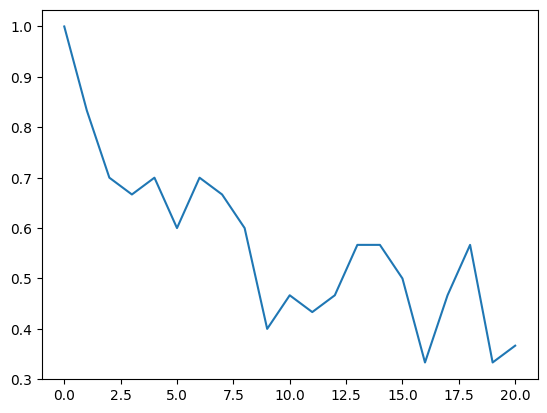

In [35]:
print(list_accuracy)
plt.plot(list(range(0, 21)), list_accuracy)
# plt.plot(list(range(0, 21)), list_loss)
plt.show()

[0.0006601435015909374, 1.6884537935256958, 3.962431181105785, 5.1199954350789385, 5.752538839975993, 3.815319299697876, 4.467962741851807, 3.867816209793091, 2.3995757897694907, 6.068544069925944, 5.987120707829793, 7.146831671396892, 5.0030903816223145, 4.067257483800252, 6.058703184127808, 4.6581025918324785, 6.34071159362793, 4.360821167627971, 5.751536766688029, 5.5470757484436035, 6.7048923174540205]


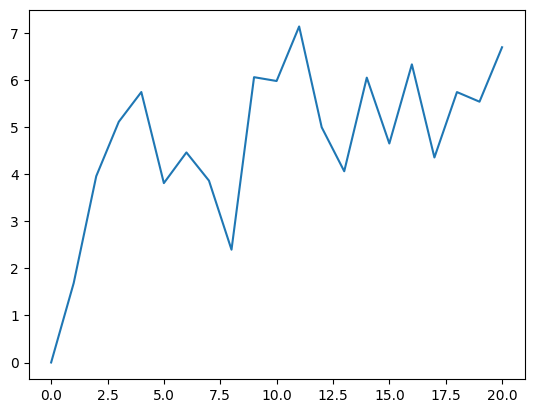

In [36]:
print(list_loss)
# plt.plot(list(range(0, 21)), list_accuracy)
plt.plot(list(range(0, 21)), list_loss)
plt.show()